In [1]:
using ModelingToolkit
using NeuralPDE
using DiffEqFlux
using Flux
using Plots
using GalacticOptim
using Test
using Optim
using CUDA

In [2]:
@parameters x, t, θ
@variables u(..)
@derivatives Dxx''~x
@derivatives Dtt''~t
@derivatives Dx'~x
@derivatives Dt'~t

((D'~t),)

In [3]:
cb = function (p,l)
    println("Current loss is: $l")
    return false
end

#3 (generic function with 1 method)

In [20]:
problem = 4;

In [21]:
if problem == 1
name="Heat1.pdf"
print("Solving 1D Heat equation")
k = 1
eq = Dt(u(x,t,θ)) ~ k*Dxx(u(x,t,θ)) 
bcs = [ u(0,t,θ) ~ 0.,# for all t > 0 << Boundary Conditions
        u(1,t,θ) ~ 0.,# for all t > 0 << Boundary Conditions
        u(x,0,θ) ~ 6*sin(pi*x)] #for all 0 < x < 1 << Initial Conditions

analyticSol(x,t) = 6*sin(pi*x)*exp(-(pi^2*t))
end

if problem == 2
name="Wave1.pdf"
c = 1
print("Solving 1D Wave equation")
eq = Dtt(u(x,t,θ)) ~ c*Dxx(u(x,t,θ))
    
bcs = [u(0,t,θ) ~ 0.,# for all t > 0
           u(1,t,θ) ~ 0.,# for all t > 0
           u(x,0,θ) ~ x*(1. - x), #for all 0 < x < 1
           Dt(u(x,0,θ)) ~ 0. ] #for all  0 < x < 1]

analyticSol(x,t) =  sum([(8/(k^3*pi^3)) * sin(k*pi*x)*cos(k*pi*t) for k in 1:2:500]) 
end

if problem == 3
name = "Heat2.pdf"
print("Solving 1D Heat equation")
eq = Dt(u(x,t,θ)) ~ 9*Dxx(u(x,t,θ))
bcs = [ u(0,t,θ) ~ 0.,# for all t > 0 << Boundary Conditions
        u(2,t,θ) ~ 8.,# for all t > 0 << Boundary Conditions
        u(x,0,θ) ~ 2*x^2]# for all 0 < x < 1 << Initial Conditions

analyticSol(x,t) = 4*x - sum([ (64/(k*pi)^3)*exp(-(3*pi*k/2)^2*t)*sin(k*pi*x/2) for k in 1:2:100])
end

if problem == 4
name="Wave2.pdf"
print("Solving 1D wave equation")
eq = Dtt(u(x,t,θ)) ~ 4*Dxx(u(x,t,θ))
bcs = [u(0,t,θ) ~ 0.,# for all t > 0 << Boundary Conditions
        u(1,t,θ) ~ 0.,# for all t > 0 << Boundary Conditions
        u(x,0,θ) ~ sin(pi*x),# for all 0 < x < 1 << Initial Conditions
        Dt(u(x,0,θ)) ~ 0] # for all 0 < x < 1 << Initial Conditions

analyticSol(x,t) = sin(pi*x)*cos(2*pi*t)
end

Solving 1D Heat equation

In [22]:
domains = [x ∈ IntervalDomain(0.0,1.),
           t ∈ IntervalDomain(0.0,1.)]
# Discretization
dx = 0.1

0.1

In [23]:
chain = FastChain(FastDense(2,16,Flux.σ),FastDense(16,16,Flux.σ),FastDense(16,1))

discretization = PhysicsInformedNN(dx,
                                   chain,
                                   init_params = nothing;
                                   phi = nothing,
                                   autodiff=false, 
                                   derivative = nothing,
                                   strategy = GridTraining()) # GridTraining() or StochasticTraining()

pde_system = PDESystem(eq,bcs,domains,[x,t],[u])
prob = discretize(pde_system,discretization)

OptimizationProblem. In-place: true
u0: Float32[-0.3750638, -0.21602306, 0.41499817, -0.30357847, 0.30767897, 0.48718348, -0.5381676, 0.027368465, -0.22838178, 0.4955177  …  0.11404201, -0.505619, -0.48030135, 0.31882396, -0.06669527, -0.14274372, -0.58574134, 0.021037906, -0.26964808, 0.0]

In [ ]:
opt = Optim.BFGS()
numIter = 1000
res = GalacticOptim.solve(prob,opt;cb=cb,maxiters=numIter)
phi = discretization.phi

# res = GalacticOptim.solve(prob,ADAM(0.1);maxiters=500)
# phi = discretization.phi

In [38]:
xs = range(0,stop=1,length=300)
ts = range(0,stop=1,length=300)
# xs,ts = [domain.domain.lower:0.1*dx:domain.domain.upper for domain in domains]

u_predict = reshape([first(phi([x,t],res.minimizer)) for x in xs for t in ts],(length(xs),length(ts)))
u_real = reshape([analyticSol(x,t) for x in xs for t in ts], (length(xs),length(ts)))
diff_u = abs.(u_predict .- u_real);

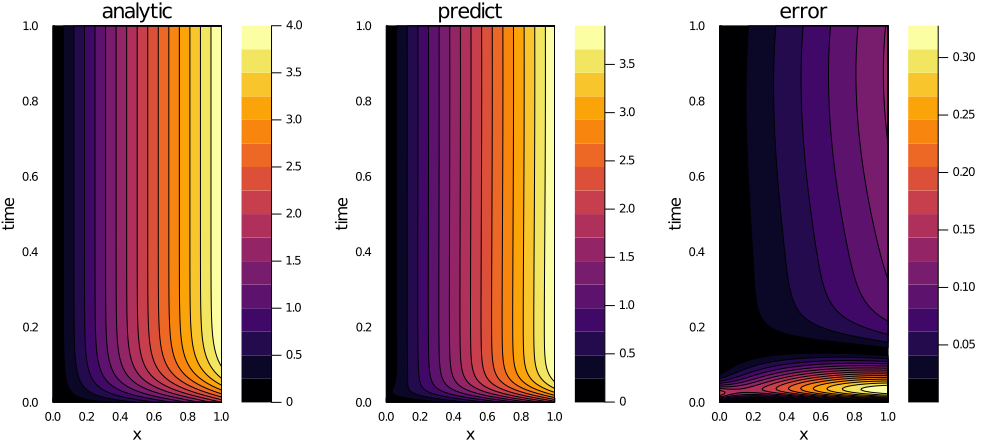

In [39]:
p1 = plot(xs,ts,u_real, linetype=:contourf,title = "analytic");
xlabel!("x")
ylabel!("time")
p2 =plot(xs,ts,u_predict, linetype=:contourf,title = "predict");
xlabel!("x")
ylabel!("time")
p3 = plot(xs, ts, diff_u,linetype=:contourf,title = "error");
xlabel!("x")
ylabel!("time")
plot(p1,p2,p3,layout=(1,3),size = (1000, 440))
# savefig(name)

In [ ]:
xs,ts = [domain.domain.lower:dx:domain.domain.upper for (dx,domain) in zip([dx,dt],domains)]

u_real = [reshape([analyticSol(x,t) for x in xs], (length(xs)))  for t in ts ]

u_predict = [reshape([first(phi([x,t],res.minimizer)) for x in xs  ], (length(xs)))  for t in ts ]


anim = @animate for i=1:length(ts)
  p1 = plot(xs, u_real[i], linetype=:contourf, title = "real, t = $(ts[i])",titlefont=20);
  p2 = plot(xs, u_predict[i], linetype=:contourf,title = "predict, t = $(ts[i])",titlefont=20);
  plot(p1,p2,layout=(1,2),size = (2000, 1100),dpi=100,
        xtickfont = font(16),ytickfont = font(16),
    ztickfont = font(16))
end
gif(anim, fps=1)